In [1]:
import warnings
from pathlib import Path
from itertools import combinations

import pandas as pd
from matplotlib import pyplot as plt

from plotting import COLOR_ALPHAFOLD_ROSETTAFOLD, COLOR_Y2H

In [2]:
zhang_core_path = Path('../output/AFRF-core_human.tsv')
if not zhang_core_path.exists():
    raise UserWarning('Need to run Y2H_AlphaFold_RosettaFold_human.ipynb to generate the -core dataset before running this notebook.')
zhang_core = pd.read_csv(zhang_core_path,
                         sep='\t',
                         index_col='pair')
zhang_core['uniprot_ac_a'] = zhang_core['Protein1']
zhang_core['uniprot_ac_b'] = zhang_core['Protein2']

In [3]:
def load_pubmed_to_date_mapping():
    in_path = Path('../data/processed/pmid_dates.csv')
    df = pd.read_csv(in_path)
    if df['pmid'].duplicated().any():
        raise UserWarning("Duplicate PMIDs in pmid_to_date")
    df['PubDate_edited'] = (df['best_date']
                            .str.replace('Winter', 'Dec')
                            .str.replace('Fall', 'Sep')
                            .str.replace('Spring', 'Mar')
                            .str.replace('Summer', 'Jun')
                            .str.replace(r'(?P<one>[A-Z][a-z][a-z])-[A-Z][a-z][a-z]',
                                        lambda x: x.group('one'), regex=True)
                            .str.replace(r'(?P<one>[A-Z][a-z][a-z] [0-9]{1,2})-.*',
                                        lambda x: x.group('one'), regex=True)
                            .str.replace(r'(?P<one>[0-9]{1,2})-[0-9]{1,2}',
                                        lambda x: x.group('one'), regex=True))
    if pd.to_datetime(df['PubDate_edited'], errors='coerce').isnull().any():
        print(df.loc[pd.to_datetime(df['PubDate_edited'], errors='coerce').isnull()])
        raise UserWarning("Some dates could not be parsed even after editing")
    df['PubDate_edited'] = pd.to_datetime(df['PubDate_edited'])
    pmid_to_date = df.set_index('pmid')['PubDate_edited']
    return pmid_to_date


def load_lit_bm_24_human(gene_id='uniprot_ac'):
    lit = pd.read_csv('../data/internal/Lit-24-human.tsv', sep='\t')
    lit = lit.loc[lit['category'] == 'Lit-BM', :]
    evid = pd.read_csv('../data/internal/Lit-24-human_evidence.tsv', sep='\t')

    pmid_date = load_pubmed_to_date_mapping()
    has_invalid_pmid = ((evid['pubmed_id'] > 50000000)
                    & evid['pubmed_id'].astype(str).str.startswith('8888'))
    if evid.loc[~has_invalid_pmid, "pubmed_id"].max() > pmid_date.index.max():
        warnings.warn("Pubmed ID to date mapping is too old")
    evid["pair"] = evid[f"{gene_id}_a"] + "_" + evid[f"{gene_id}_b"]
    lit["pair"] = lit[f"{gene_id}_a"] + "_" + lit[f"{gene_id}_b"]
    lit = lit.drop_duplicates("pair")
    if lit["pair"].duplicated().any():
        raise UserWarning("unexpected duplicates")
    lit = lit.set_index("pair")
    evid["date"] = evid["pubmed_id"].map(pmid_date)
    first_date = (
        evid.sort_values("date").drop_duplicates("pair").set_index("pair")["date"]
    )
    lit["date_first_pub"] = lit.index.map(first_date)
    second_date = evid.sort_values("date").groupby("pair").nth(1)["date"]
    lit["date_second_pub"] = lit.index.map(second_date)
    lit = lit.sort_values("date_first_pub")

    return lit

def load_I3D_exp_24(organism):
    i3d = pd.read_csv(
        f"../data/external/interactome3d_2024-12_{organism}_interactions.dat", sep="\t"
    )
    i3d = i3d.loc[i3d["TYPE"] == "Structure", :]

    return i3d


def load_lit_24_human(gene_id='uniprot_ac'):
    lit = pd.read_csv('../data/internal/Lit-24-human.tsv', sep='\t')
    lit["pair"] = lit[f"{gene_id}_a"] + "_" + lit[f"{gene_id}_b"]
    lit = lit.drop_duplicates("pair")
    if lit["pair"].duplicated().any():
        raise UserWarning("unexpected duplicates")
    lit = lit.set_index("pair")

    return lit


def load_uniprot_proteome_from_fasta(tax_id):
    uniprot_proteome_ids = {
        9606: 'UP000005640',
        10090: 'UP000000589',
        6239: 'UP000001940',
        3702: 'UP000006548',
        83333: 'UP000000625',
        559292: 'UP000002311',
        2697049: 'UP000464024',
        7227: 'UP000000803'
    }
    with open('../data/external/uniprot_2022-03-02/{}_{}.fasta'.format(uniprot_proteome_ids[tax_id], tax_id), 'r') as f:
        proteins = {l.split('|')[1] for l in f.readlines() if l.startswith('>')}
    return proteins


valid_uniprot_acs = load_uniprot_proteome_from_fasta(9606)
hi = pd.read_csv('../data/internal/HI_union_uniprot_ac.tsv',
                 sep='\t',
                 index_col=0)
hi = hi.loc[hi['uniprot_ac_a'].isin(valid_uniprot_acs) & hi['uniprot_ac_b'].isin(valid_uniprot_acs), :]
hi = hi.loc[hi['uniprot_ac_a'] != hi['uniprot_ac_b'], :]
huri = hi.loc[hi['in_HI_III'], :].copy()
i3d = load_I3D_exp_24('h_sapiens')
lit = load_lit_bm_24_human()
lit = lit.reset_index().rename(columns={'index': 'pair'})
lit = lit.set_index('pair')
i3d['uniprot_ac_a'] = i3d[['PROT1', 'PROT2']].min(axis=1)
i3d['uniprot_ac_b'] = i3d[['PROT1', 'PROT2']].max(axis=1)
i3d['pair'] = i3d['uniprot_ac_a'] + '_' + i3d['uniprot_ac_b']
i3d = i3d.set_index('pair')
lit_all = load_lit_24_human()

In [4]:
def has_pdb_hit(df, algn):

    uq = pd.unique(df[['uniprot_ac_a', 'uniprot_ac_b']].to_numpy().ravel())
    sub = (
        algn.loc[algn['query'].isin(uq), ['query', 'PDB_ID', 'chain_ID']]
            .drop_duplicates()
    )

    # per (PDB_ID, query): set of chains it hits in that PDB
    qchains = (
        sub.groupby(['PDB_ID', 'query'], sort=False)['chain_ID']
        .agg(lambda s: frozenset(s.unique()))
        .reset_index()
    )

    # build a set of UniProt pairs that share at least one PDB with >=2 chains across the pair
    pair_ok = set()
    for _, grp in qchains.groupby('PDB_ID', sort=False):
        qs = grp['query'].to_numpy()
        cs = grp['chain_ID'].to_list()
        if len(qs) < 2:
            continue
        for i, j in combinations(range(len(qs)), 2):
            if len(cs[i] | cs[j]) >= 2:
                a, b = qs[i], qs[j]
                if a > b:
                    a, b = b, a
                pair_ok.add((a, b))

    return [(x, y) in pair_ok for x, y in df[['uniprot_ac_a', 'uniprot_ac_b']].itertuples(index=False) ]


m8_columns = ['query', 
             'target', 
            'pident', 
            'alnlen', 
            'mismatches',
            'gapopens', 
            'qstart', 
            'qend', 
            'tstart', 
            'tend', 
            'evalue', 
            'bits']
algn = pd.read_csv('../data/external/PDB_aa_seqs/results.m8', 
                   names=m8_columns,
                   sep='\t')
algn['PDB_ID'] = algn['target'].apply(lambda x: x.split('_')[0])
algn['chain_ID'] = algn['target'].apply(lambda x: x.split('_')[1])

zhang_core['has_PDB_hit'] = has_pdb_hit(zhang_core, algn)
huri['has_PDB_hit'] = has_pdb_hit(huri, algn)

15799 2380 13419 5681 7738 1502 6236 3263 2973


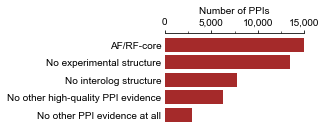

In [5]:
has_struct = zhang_core.index.isin(i3d.index)
has_homo_struct = zhang_core['has_PDB_hit']
in_hqb = zhang_core.index.isin(i3d.index) | zhang_core.index.isin(lit.index) | zhang_core.index.isin(hi.index)

print(
    zhang_core.shape[0],
    has_struct.sum(),
    (~has_struct).sum(),
        (~has_struct & has_homo_struct).sum(),
        (~has_struct & ~has_homo_struct).sum(),
        (~has_struct & ~has_homo_struct & in_hqb).sum(),
        (~has_struct & ~has_homo_struct & ~in_hqb).sum(),        
        (~has_struct & ~has_homo_struct & ~in_hqb & zhang_core.index.isin(lit_all.index)).sum(),        
        (~has_struct & ~has_homo_struct & ~in_hqb & ~zhang_core.index.isin(lit_all.index)).sum(),        

)

counts = [
    zhang_core.shape[0],
    (~has_struct).sum(),
    (~has_struct & ~has_homo_struct).sum(),
    (~has_struct & ~has_homo_struct & ~in_hqb).sum(),        
    (~has_struct & ~has_homo_struct & ~in_hqb & ~zhang_core.index.isin(lit_all.index)).sum(),        

]



labels = ['AF/RF-core',
          'No experimental structure',
        'No interolog structure',
          'No other high-quality PPI evidence',
          'No other PPI evidence at all',
          ]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=1.7)
ax.barh(width=counts, y=labels, color=COLOR_ALPHAFOLD_ROSETTAFOLD)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticks(range(0, 15001, 5000))
ax.set_xticks(range(0, 15001, 2500), minor=True)
ax.set_xlim(0, 15000)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xticklabels([f'{x:,}' for x in ax.get_xticks()])
for loc in ['left', 'right', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.set_xlabel('Number of PPIs')
fig.savefig('../figures/AlphaFoldRoseTTAFold-core_flow-chart_bar.pdf',
            bbox_inches='tight')

50985 374 50611 1417 49194 5324 43870 1235 42635


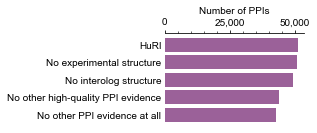

In [6]:
has_struct = (huri.index.isin(i3d.index))
has_homo_struct = huri['has_PDB_hit']
hi_prev = hi.loc[hi['in_Rual'] | hi['in_Venkatesan'] | hi['in_Yu'] | hi['in_Rolland'] | hi['in_Yang'], :].copy()
in_hqb = huri.index.isin(i3d.index) | huri.index.isin(lit.index) | huri.index.isin(hi_prev.index)

print(
    huri.shape[0],
    has_struct.sum(),
    (~has_struct).sum(),
        (~has_struct & has_homo_struct).sum(),
        (~has_struct & ~has_homo_struct).sum(),
        (~has_struct & ~has_homo_struct & in_hqb).sum(),
        (~has_struct & ~has_homo_struct & ~in_hqb).sum(),        
        (~has_struct & ~has_homo_struct & ~in_hqb & huri.index.isin(lit_all.index)).sum(),        
        (~has_struct & ~has_homo_struct & ~in_hqb & ~huri.index.isin(lit_all.index)).sum(),        

)

counts = [
    huri.shape[0],
    (~has_struct).sum(),
    (~has_struct & ~has_homo_struct).sum(),
    (~has_struct & ~has_homo_struct & ~in_hqb).sum(),        
    (~has_struct & ~has_homo_struct & ~in_hqb & ~huri.index.isin(lit_all.index)).sum(),        
]




labels = ['HuRI',
          'No experimental structure',
        'No interolog structure',
          'No other high-quality PPI evidence',
          'No other PPI evidence at all',
          ]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=1.7)
ax.barh(width=counts, y=labels, color=COLOR_Y2H)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticks(range(0, 50001, 25000))
ax.set_xticks(range(0, 50001, 5000), minor=True)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticklabels([f'{int(x):,}' for x in ax.get_xticks()])
for loc in ['left', 'right', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.set_xlabel('Number of PPIs')
fig.savefig('../figures/HuRI_flow-chart_bar.pdf',
            bbox_inches='tight')

15799 2380 13419 5681 7738 1502 6236 3263 2973
50985 374 50611 1417 49194 5324 43870 1235 42635


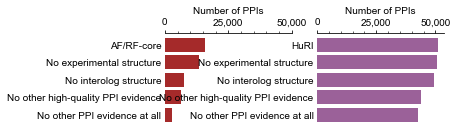

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(w=2.5 * 2, h=1.7)

ax = axs[0]
has_struct = zhang_core.index.isin(i3d.index)
has_homo_struct = zhang_core['has_PDB_hit']
in_hqb = zhang_core.index.isin(i3d.index) | zhang_core.index.isin(lit.index) | zhang_core.index.isin(hi.index)

print(
    zhang_core.shape[0],
    has_struct.sum(),
    (~has_struct).sum(),
        (~has_struct & has_homo_struct).sum(),
        (~has_struct & ~has_homo_struct).sum(),
        (~has_struct & ~has_homo_struct & in_hqb).sum(),
        (~has_struct & ~has_homo_struct & ~in_hqb).sum(),        
        (~has_struct & ~has_homo_struct & ~in_hqb & zhang_core.index.isin(lit_all.index)).sum(),        
        (~has_struct & ~has_homo_struct & ~in_hqb & ~zhang_core.index.isin(lit_all.index)).sum(),        

)

counts = [
    zhang_core.shape[0],
    (~has_struct).sum(),
    (~has_struct & ~has_homo_struct).sum(),
    (~has_struct & ~has_homo_struct & ~in_hqb).sum(),        
    (~has_struct & ~has_homo_struct & ~in_hqb & ~zhang_core.index.isin(lit_all.index)).sum(),        

]



labels = ['AF/RF-core',
          'No experimental structure',
        'No interolog structure',
          'No other high-quality PPI evidence',
          'No other PPI evidence at all',
          ]

ax.barh(width=counts, y=labels, color=COLOR_ALPHAFOLD_ROSETTAFOLD)

ax = axs[1]
has_struct = (huri.index.isin(i3d.index))
has_homo_struct = huri['has_PDB_hit']
hi_prev = hi.loc[hi['in_Rual'] | hi['in_Venkatesan'] | hi['in_Yu'] | hi['in_Rolland'] | hi['in_Yang'], :].copy()
in_hqb = huri.index.isin(i3d.index) | huri.index.isin(lit.index) | huri.index.isin(hi_prev.index)

print(
    huri.shape[0],
    has_struct.sum(),
    (~has_struct).sum(),
        (~has_struct & has_homo_struct).sum(),
        (~has_struct & ~has_homo_struct).sum(),
        (~has_struct & ~has_homo_struct & in_hqb).sum(),
        (~has_struct & ~has_homo_struct & ~in_hqb).sum(),        
        (~has_struct & ~has_homo_struct & ~in_hqb & huri.index.isin(lit_all.index)).sum(),        
        (~has_struct & ~has_homo_struct & ~in_hqb & ~huri.index.isin(lit_all.index)).sum(),        

)

counts = [
    huri.shape[0],
    (~has_struct).sum(),
    (~has_struct & ~has_homo_struct).sum(),
    (~has_struct & ~has_homo_struct & ~in_hqb).sum(),        
    (~has_struct & ~has_homo_struct & ~in_hqb & ~huri.index.isin(lit_all.index)).sum(),        
]




labels = ['HuRI',
          'No experimental structure',
        'No interolog structure',
          'No other high-quality PPI evidence',
          'No other PPI evidence at all',
          ]

ax.barh(width=counts, y=labels, color=COLOR_Y2H)

for ax in axs:
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xticks(range(0, 50001, 25000))
    ax.set_xticks(range(0, 50001, 5000), minor=True)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels([f'{int(x):,}' for x in ax.get_xticks()])
    for loc in ['left', 'right', 'bottom']:
        ax.spines[loc].set_visible(False)
    ax.yaxis.set_tick_params(length=0)
    ax.set_xlabel('Number of PPIs')
fig.savefig('../figures/AFRF_HuRI_flow-chart_bar.pdf',
            bbox_inches='tight')

In [8]:
zhang_published = pd.read_excel('../data/external/science.adt1630_data_s1_to_s8.xlsx', 
                    sheet_name='Data S3', skiprows=15)
if not (zhang_published['Protein1'] < zhang_published['Protein2']).all():
    raise UserWarning('expected sorted')
zhang_published['pair'] = zhang_published['Protein1'] + '_' + zhang_published['Protein2']
if zhang_published['pair'].duplicated().any():
    raise UserWarning('unexpected duplicates')
zhang_published = zhang_published.set_index('pair')
zhang_published['uniprot_ac_a'] = zhang_published['Protein1']
zhang_published['uniprot_ac_b'] = zhang_published['Protein2']

In [9]:
has_struct = zhang_core.index.isin(i3d.index)
has_homo_struct = zhang_core['has_PDB_hit']
in_hqb = zhang_core.index.isin(i3d.index) | zhang_core.index.isin(lit.index) | zhang_core.index.isin(hi.index)
zhang_core['strictly_novel'] = (~has_struct & ~has_homo_struct & ~in_hqb & ~zhang_core.index.isin(lit_all.index))

zhang_published['has_PDB_hit'] = has_pdb_hit(zhang_published, algn)
has_struct = zhang_published.index.isin(i3d.index)
has_homo_struct = zhang_published['has_PDB_hit']
in_hqb = zhang_published.index.isin(i3d.index) | zhang_published.index.isin(lit.index) | zhang_published.index.isin(hi.index)
zhang_published['strictly_novel'] = (~has_struct & ~has_homo_struct & ~in_hqb & ~zhang_published.index.isin(lit_all.index))

In [10]:
zhang_published['strictly_novel'].sum()

4789

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_74627/1686738537.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['All pairs', 'Strictly\nnovel pairs'], rotation=90)


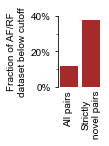

In [11]:
f = [ (zhang_published.shape[0] - zhang_core.shape[0])  / zhang_published.shape[0] * 100,
(zhang_published['strictly_novel'].sum() - zhang_core['strictly_novel'].sum()) / zhang_published['strictly_novel'].sum() * 100]



fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=0.8, h=1.3)
ax.bar(['All pairs', 'Strictly novel'], f,
       color=COLOR_ALPHAFOLD_ROSETTAFOLD)
ax.set_ylabel('Fraction of AF/RF\ndataset below cutoff')
ax.xaxis.set_ticklabels(['All pairs', 'Strictly\nnovel pairs'], rotation=90)
for loc in ['top', 'right', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_yticks([0, 20, 40])
ax.set_yticks([0, 10, 20, 30, 40], minor=True)
ax.yaxis.set_ticklabels([f'{y:.0f}%' for y in ax.get_yticks()])
fig.savefig('../figures/published_overlap_subset_Zhang-et-al_cutoff-by-novel_bar.pdf',
            bbox_inches='tight')

In [12]:
tm_proteins = set(pd.read_csv('../data/external/uniprotkb_organism_id_9606_AND_reviewed_AND_KW0812_transmembrane_2025_10_09.tsv',
                  sep='\t')['Entry'])
#print(len(tm_proteins))
both = (zhang_published['Protein1'].isin(tm_proteins)
       & zhang_published['Protein2'].isin(tm_proteins))
print(f'{both.sum()} ({both.sum()/zhang_published.shape[0]:.0%}) TM-TM pairs in all Zhang et al. PPIs')
one = (zhang_published['Protein1'].isin(tm_proteins)
       ^ zhang_published['Protein2'].isin(tm_proteins))
print(f'{one.sum()} ({one.sum()/zhang_published.shape[0]:.0%}) TM-NonTM pairs in all Zhang et al. PPIs')

n_both_and_novel = (both & zhang_published['strictly_novel']).sum()
print(f"{n_both_and_novel} ({n_both_and_novel/zhang_published['strictly_novel'].sum():.0%}) TM-TM pairs in strictly novel Zhang et al. PPIs")
n_one_and_novel = (one & zhang_published['strictly_novel']).sum()
print(f"{n_one_and_novel} ({n_one_and_novel/zhang_published['strictly_novel'].sum():.0%}) TM-NonTM pairs in strictly novel Zhang et al. PPIs")

2575 (14%) TM-TM pairs in all Zhang et al. PPIs
2119 (12%) TM-NonTM pairs in all Zhang et al. PPIs
1028 (21%) TM-TM pairs in strictly novel Zhang et al. PPIs
847 (18%) TM-NonTM pairs in strictly novel Zhang et al. PPIs


In [13]:
sec_proteins = set(pd.read_csv('../data/external/uniprotkb_organism_id_9606_AND_reviewed_AND_KW0964_secreted_2025_12_03.tsv',
                  sep='\t')['Entry'])
sec_proteins = sec_proteins.difference(tm_proteins)
print(len(sec_proteins))
both = (zhang_published['Protein1'].isin(sec_proteins)
       & zhang_published['Protein2'].isin(sec_proteins))
print(f'{both.sum()} ({both.sum()/zhang_published.shape[0]:.0%}) secreted-secreted pairs in all Zhang et al. PPIs')
one = (zhang_published['Protein1'].isin(sec_proteins)
       ^ zhang_published['Protein2'].isin(sec_proteins))
print(f'{one.sum()} ({one.sum()/zhang_published.shape[0]:.0%}) secreted-Nonsecreted pairs in all Zhang et al. PPIs')

n_both_and_novel = (both & zhang_published['strictly_novel']).sum()
print(f"{n_both_and_novel} ({n_both_and_novel/zhang_published['strictly_novel'].sum():.0%}) secreted-secreted pairs in strictly novel Zhang et al. PPIs")
n_one_and_novel = (one & zhang_published['strictly_novel']).sum()
print(f"{n_one_and_novel} ({n_one_and_novel/zhang_published['strictly_novel'].sum():.0%}) secreted-Nonsecreted pairs in strictly novel Zhang et al. PPIs")

1826
598 (3%) secreted-secreted pairs in all Zhang et al. PPIs
899 (5%) secreted-Nonsecreted pairs in all Zhang et al. PPIs
253 (5%) secreted-secreted pairs in strictly novel Zhang et al. PPIs
386 (8%) secreted-Nonsecreted pairs in strictly novel Zhang et al. PPIs
